In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 29 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
# 런타임 다시 시작 후 실행
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 가이드 프로젝트/train.csv')
test = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 가이드 프로젝트/test.csv')

#전처리

###결측값 여부 컬럼 추가

<Figure size 800x500 with 0 Axes>

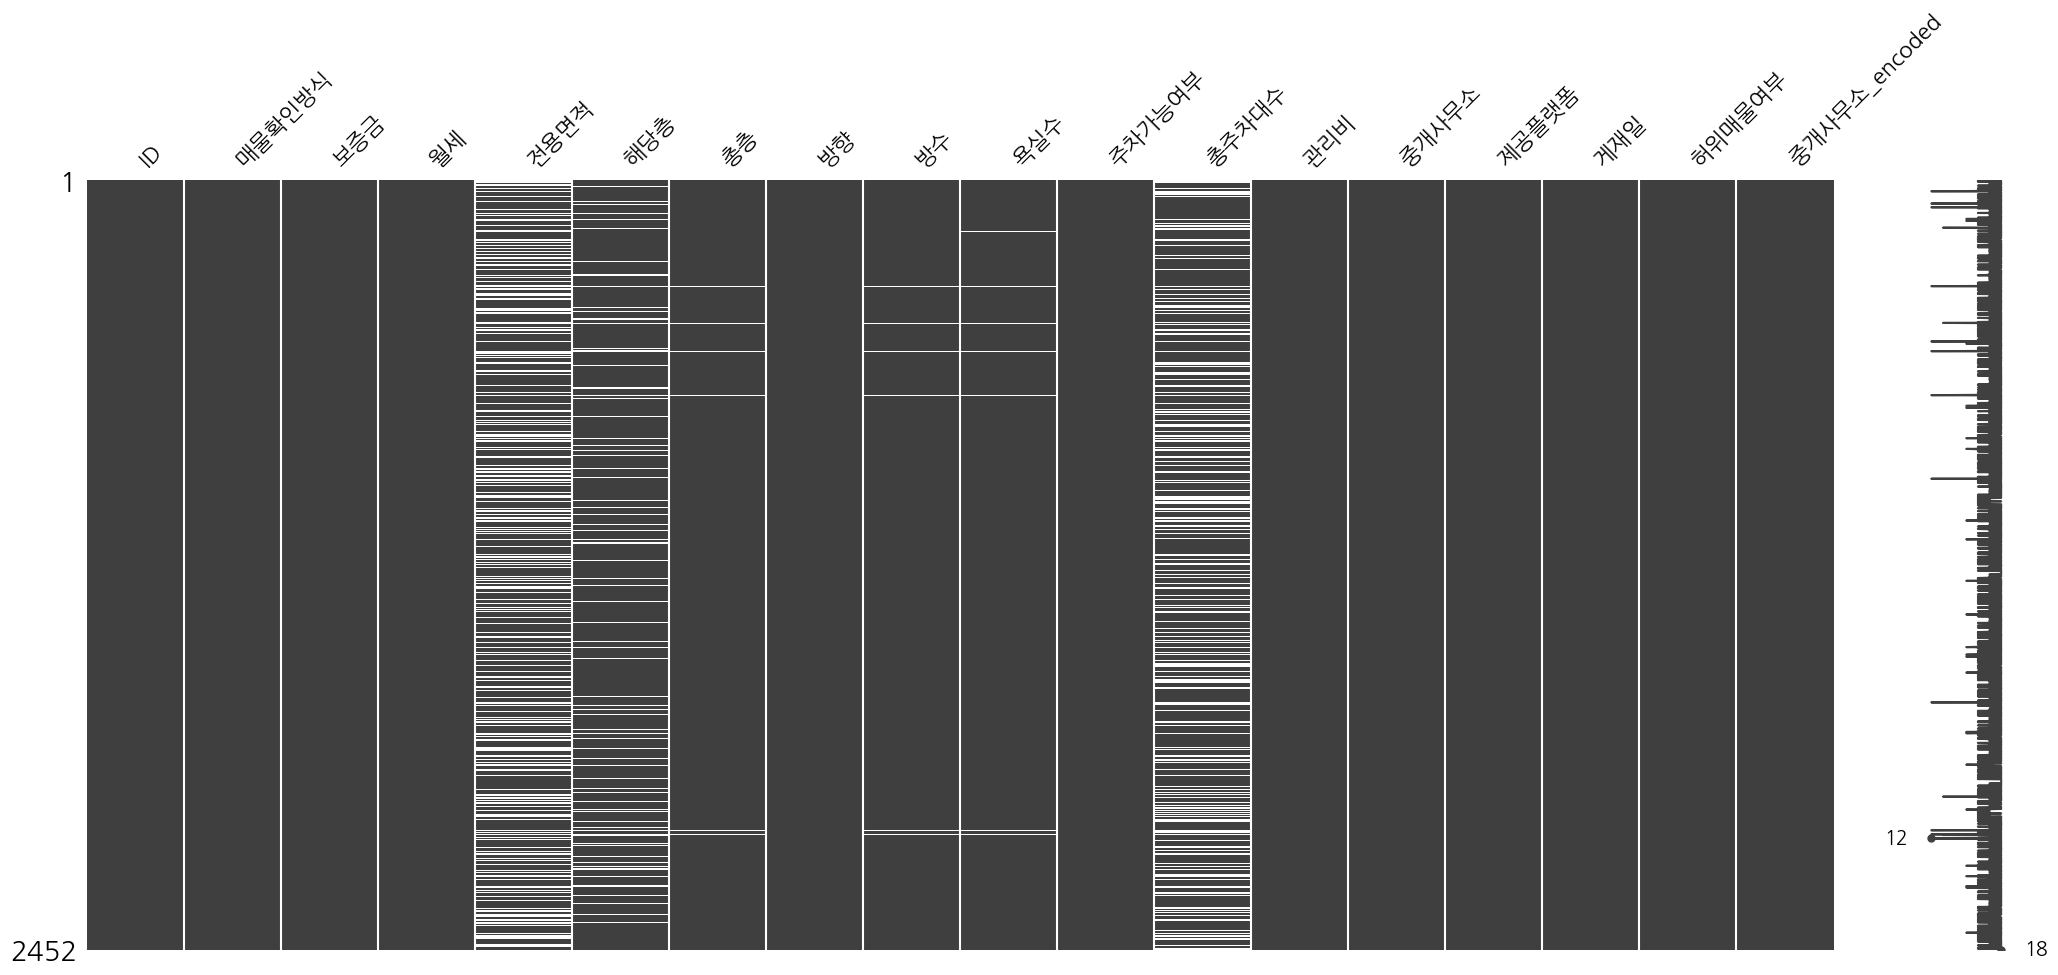

In [ ]:
import missingno as ms
plt.figure(figsize=(8, 5))
ms.matrix(train)
plt.show()

<Figure size 800x500 with 0 Axes>

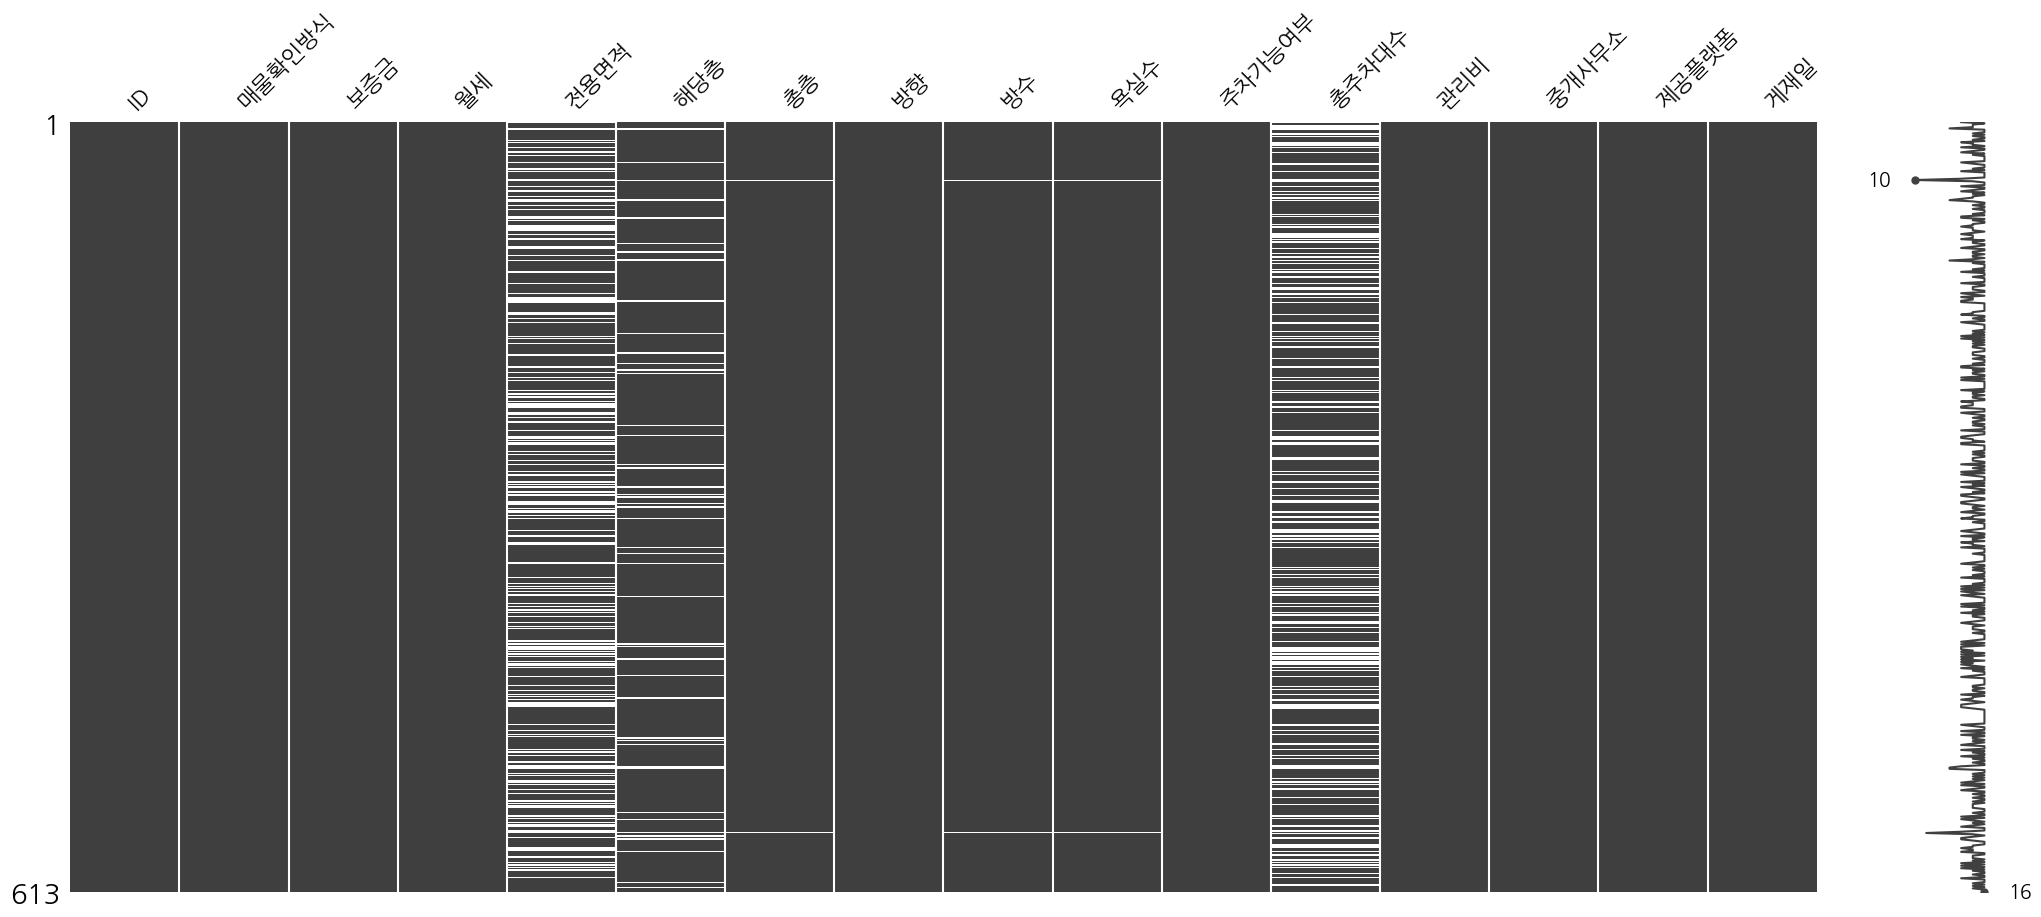

In [ ]:
plt.figure(figsize=(8, 5))
ms.matrix(test)
plt.show()

In [ ]:
train['결측여부'] = train.isna().any(axis=1).map({True: '결측 있음', False: '결측 없음'})

missing_ratio = train.groupby(['결측여부', '허위매물여부']).size().reset_index(name='count')
missing_ratio['비율'] = missing_ratio.groupby('결측여부')['count'].transform(lambda x: x / x.sum())

fig = px.bar(missing_ratio,
             x='결측여부',
             y='비율',
             color='허위매물여부',
             text=missing_ratio['비율'].map(lambda x: f"{x:.1%}"),
             barmode='group',
             title="전체 데이터에서 결측 여부에 따른 허위매물 비율",
             labels={'비율': '비율', '결측여부': '결측 여부', '허위매물여부': '허위매물 여부'})

fig.show()

In [ ]:
missing_columns = train.isna().sum()
missing_columns = missing_columns[missing_columns > 0].index  # 결측값이 1개 이상 있는 컬럼만 선택

# 결과를 저장할 리스트
plot_data = []

# 각 컬럼별로 결측 여부에 따른 허위매물 비율 계산
for col in missing_columns:
    train['결측여부'] = train[col].isna().map({True: '결측 있음', False: '결측 없음'})

    # 그룹별 허위매물여부(0,1) 비율 계산
    missing_ratio = train.groupby(['결측여부', '허위매물여부']).size().reset_index(name='count')
    missing_ratio['비율'] = missing_ratio.groupby('결측여부')['count'].transform(lambda x: x / x.sum())
    missing_ratio['컬럼'] = col  # 현재 컬럼명 추가
    plot_data.append(missing_ratio)

plot_df = pd.concat(plot_data, ignore_index=True)

fig = px.bar(plot_df,
             x='컬럼',
             y='비율',
             color='허위매물여부',
             text=plot_df['비율'].map(lambda x: f"{x:.1%}"),  # 비율을 퍼센트로 표시
             barmode='group',
             title="각 컬럼별 결측 여부에 따른 허위매물 비율",
             labels={'비율': '비율', '컬럼': '컬럼명', '허위매물여부': '허위매물 여부'},
             facet_col='결측여부',
             category_orders={'결측여부': ['결측 있음', '결측 없음']})  # 결측 여부 순서 지정

fig.update_layout(
    height=600,
    width=1000,
    showlegend=True
)

fig.show()

In [ ]:

train['결측_개수'] = train.isna().sum(axis=1)

# 그룹별 허위매물여부(0,1) 비율 계산
missing_count_ratio = train.groupby(['결측_개수', '허위매물여부']).size().reset_index(name='count')

# 전체 개수 대비 비율 계산
missing_count_ratio['비율'] = missing_count_ratio.groupby('결측_개수')['count'].transform(lambda x: x / x.sum())

# 각 그룹에 대한 개수 출력
total_count_per_group = missing_count_ratio.groupby('결측_개수')['count'].sum().reset_index(name='총 개수')

# 비율과 개수를 합쳐서 출력
missing_count_ratio = pd.merge(missing_count_ratio, total_count_per_group, on='결측_개수')

# 막대 그래프 생성
fig = px.bar(missing_count_ratio,
             x='결측_개수',
             y='비율',
             color='허위매물여부',
             text=missing_count_ratio['count'].map(lambda x: f"{x}개"),  # 각 그룹에 속한 데이터 개수 표시
             barmode='group',
             title="결측값이 있는 열의 개수에 따른 허위매물 비율과 개수",
             labels={'비율': '비율', '결측_개수': '결측 열 개수', '허위매물여부': '허위매물 여부'})

fig.update_layout(
    height=600,
    width=900,
    showlegend=True
)

fig.show()

# 각 그룹의 개수 출력 (비율과 함께)
missing_count_ratio[['결측_개수', '허위매물여부', '비율', 'count']]

,결측_개수,허위매물여부,비율,count
0,0,0,0.934851,1191
1,0,1,0.065149,83
2,1,0,0.815634,553
3,1,1,0.184366,125
4,2,0,0.823913,379
5,2,1,0.176087,81
6,3,0,0.791667,19
7,3,1,0.208333,5
8,5,0,1.000000,4
9,6,0,0.666667,8


In [ ]:
missing_counts = train.isna().sum()
missing_cols = missing_counts[missing_counts > 0].index
missing_cols

Index(['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수'], dtype='object')

In [ ]:
'''
#방법1 : 결측치여부 컬럼 추가
train['missing_flag'] = train.isnull().any(axis=1)
test['missing_flag'] = test.isnull().any(axis=1)

#방법2 : 열별로 결측치 수 추가
for col in missing_cols:
    train[f'결측여부_{col}'] = train[col].isna().astype(int)
for col in missing_cols:
    test[f'결측여부_{col}'] = test[col].isna().astype(int)
'''
#방법3 : 결측치 개수에 따른 컬럼 추가
train['missing_count'] = train.isnull().sum(axis=1)
test['missing_count'] = test.isnull().sum(axis=1)


###중개사무소

In [ ]:
import pandas as pd
#방법1 : 허위매물비율에 따른 타겟인코딩
def smoothed_target_encoding(train_df, test_df, category_col, target_col, alpha=10):
    """
    스무딩 타겟 인코딩 적용
    - train_df: 학습 데이터 (허위매물여부 컬럼 포함)
    - test_df: 테스트 데이터 (허위매물여부 컬럼 없음)
    - category_col: 중개사무소 컬럼명
    - target_col: 허위매물여부 컬럼명
    - alpha: 스무딩 강도 (클수록 전체 평균에 가깝게 조정됨)
    """
    # 전체 허위매물 평균 비율 (global mean)
    global_mean = train_df[target_col].mean()

    # 중개사무소별 허위매물 비율 및 개수 계산
    encoding_stats = train_df.groupby(category_col)[target_col].agg(['sum', 'count'])

    # 스무딩된 타겟 인코딩 값 계산
    encoding_stats['smoothed'] = (encoding_stats['sum'] + global_mean * alpha) / (encoding_stats['count'] + alpha)

    # 중개사무소 → 스무딩된 허위매물 비율 매핑
    encoding_map = encoding_stats['smoothed'].to_dict()

    # train 데이터 변환
    train_df[f'{category_col}_encoded'] = train_df[category_col].map(encoding_map)

    # test 데이터 변환 (새로운 중개사무소는 global_mean으로 대체)
    test_df[f'{category_col}_encoded'] = test_df[category_col].map(encoding_map).fillna(global_mean)

    return train_df, test_df


# 타겟 인코딩 적용
train, test = smoothed_target_encoding(train, test, '중개사무소', '허위매물여부')

#방법2 : 중개사별 그룹화

In [ ]:
train['중개사무소_빈도'] = train['중개사무소'].map(train['중개사무소'].value_counts())
test['중개사무소_빈도'] = test['중개사무소'].map(train['중개사무소'].value_counts())

In [ ]:
agency_counts = train['중개사무소'].value_counts()

train['중개사무소_Count'] = train['중개사무소'].map(agency_counts)

test['중개사무소_Count'] = test['중개사무소'].apply(
    lambda x: agency_counts[x] if x in agency_counts else -1
)

train.drop(columns={'중개사무소'},inplace=True)
test.drop(columns={'중개사무소'},inplace=True)

###결측치 대치

In [ ]:
X_train = train.drop(columns = ['허위매물여부'])
y_train = train['허위매물여부']
df = pd.concat([X_train, test])

In [ ]:
# '총층' 결측치 채우기 (평균값으로 대체)
df['총층'] = df['총층'].fillna(df['총층'].mean())

# '총층' > '해당층' 예측
train_data = df.dropna(subset=['총층', '해당층'])

X = train_data[['총층']]
y = train_data['해당층']

if df['해당층'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)

    missing_index = df['해당층'].isna()
    X_missing = df.loc[missing_index, ['총층']]

    df.loc[missing_index, '해당층'] = model.predict(X_missing).round()

# '총층' > '총주차대수' 예측
train_data = df.dropna(subset=['총층', '총주차대수'])

X = train_data[['총층']]
y = train_data['총주차대수']

if df['총주차대수'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)

    missing_index = df['총주차대수'].isna()
    X_missing = df.loc[missing_index, ['총층']]

    df.loc[missing_index, '총주차대수'] = model.predict(X_missing).round()


# '방수' 결측치 채우기 (평균값)
df['방수'] = df['방수'].fillna(df['방수'].mean())

# '방수' > '욕실수' 예측
train_data = df.dropna(subset=['방수', '욕실수'])

X = train_data[['방수']]
y = train_data['욕실수']

if df['욕실수'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)

    missing_index = df['욕실수'].isna() & df['방수'].notna()
    X_missing = df.loc[missing_index, ['방수']]

    df.loc[missing_index, '욕실수'] = model.predict(X_missing).round()

# '방수' > '전용면적' 예측
train_data = df.dropna(subset=['방수', '전용면적'])

X = train_data[['방수']]
y = train_data['전용면적']

if df['전용면적'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)

    missing_index = df['전용면적'].isna() & df['방수'].notna()
    X_missing = df.loc[missing_index, ['방수']]

    df.loc[missing_index, '전용면적'] = model.predict(X_missing)

In [ ]:
train1 = df.iloc[:len(train)]
office_stats = train1.groupby('중개사무소').agg(
    총_매물수=('보증금', 'count'),
    평균_보증금=('보증금', 'mean'),
    평균_월세=('월세', 'mean'),
    평균_전용면적=('전용면적', 'mean'),
    평균_층수=('해당층', 'mean'),
    평균_총층=('총층', 'mean'),
    평균_총주차대수=('총주차대수', 'mean'),
    평균_관리비=('관리비', 'mean'),
    평균_욕실수=('욕실수', 'mean'),
    평균_방수=('방수', 'mean'),
).reset_index()

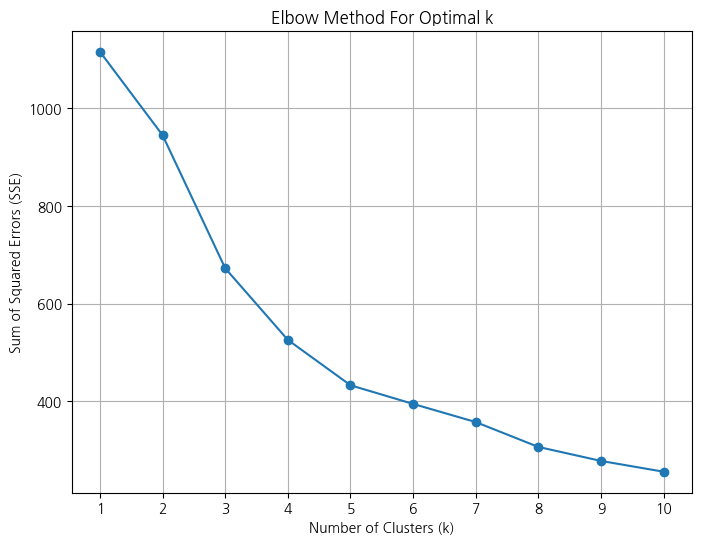

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 클러스터링을 위한 특징 선택
features = ['총_매물수', '평균_보증금', '평균_월세', '평균_관리비']

# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(office_stats[features])

# 클러스터 개수의 범위 설정
k_range = range(1, 11)

# SSE 값을 저장할 리스트
sse = []

# 다양한 k 값에 대해 KMeans 클러스터링 수행
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)  # 클러스터링의 합 내제곱 오차(SSE)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


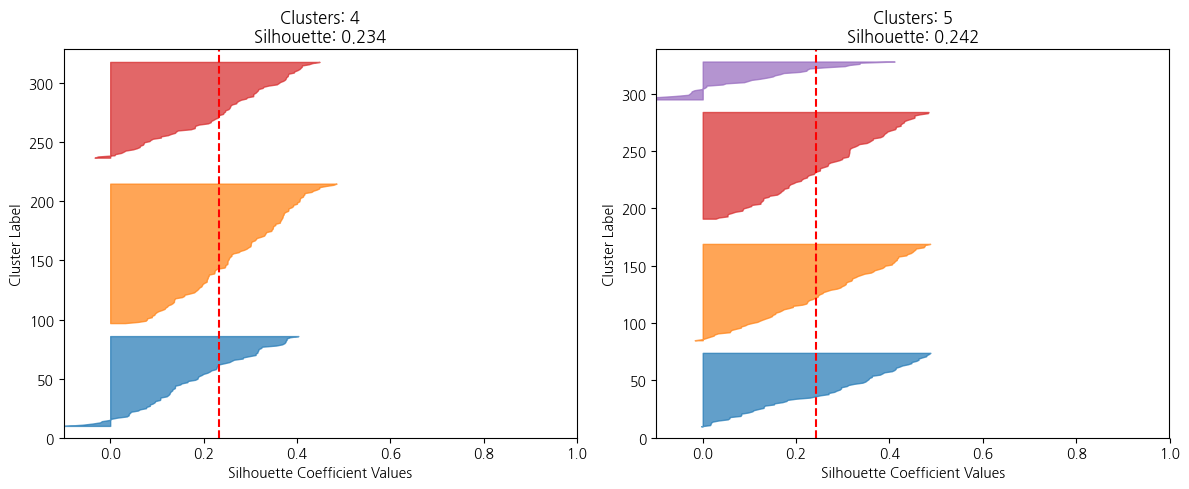

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

# k값 리스트
k_values = [4, 5]

# 실루엣 계수 시각화를 위한 플롯
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    # 개별 샘플의 실루엣 계수 계산
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

    y_lower = 10
    axes[i].set_xlim([-0.1, 1])
    axes[i].set_ylim([0, len(scaled_features) + (k + 1) * 10])

    for j in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = plt.cm.tab10(j)
        axes[i].fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10

    axes[i].axvline(x=silhouette_avg, color="red", linestyle="--")
    axes[i].set_title(f"Clusters: {k}\nSilhouette: {silhouette_avg:.3f}")
    axes[i].set_xlabel("Silhouette Coefficient Values")
    axes[i].set_ylabel("Cluster Label")

plt.tight_layout()
plt.show()


In [ ]:
# KMeans 클러스터링 적용
kmeans = KMeans(n_clusters=4, random_state=42)
office_stats['중개사무소_cluster'] = kmeans.fit_predict(scaled_features)
X_train = df.iloc[:len(train)]
# 원본 데이터에 클러스터 정보 병합
X_train = X_train.merge(office_stats[['중개사무소', '중개사무소_cluster']], on='중개사무소', how='left')

In [ ]:
test1 = df.iloc[len(train):]
office_stats = test1.groupby('중개사무소').agg(
    총_매물수=('보증금', 'count'),
    평균_보증금=('보증금', 'mean'),
    평균_월세=('월세', 'mean'),
    평균_전용면적=('전용면적', 'mean'),
    평균_층수=('해당층', 'mean'),
    평균_총층=('총층', 'mean'),
    평균_총주차대수=('총주차대수', 'mean'),
    평균_관리비=('관리비', 'mean'),
    평균_욕실수=('욕실수', 'mean'),
    평균_방수=('방수', 'mean'),
).reset_index()

In [ ]:
# train에서 사용한 scaler 적용 (새로 fit하면 안 됨!)
scaled_test_features = scaler.transform(office_stats[features])

# train에서 학습한 kmeans 모델로 test 데이터의 클러스터 예측
office_stats['중개사무소_cluster'] = kmeans.predict(scaled_test_features)
test = df.iloc[len(train):]
# test에 클러스터 정보 병합
test = test.merge(office_stats[['중개사무소', '중개사무소_cluster']], on='중개사무소', how='left')

In [ ]:
df = pd.concat([X_train,test])

###게재일 년,월 변환

In [ ]:
df['게재일'] = pd.to_datetime(df['게재일'], errors='coerce')
df['년'] = df['게재일'].dt.year
df['월'] = df['게재일'].dt.month

### 로그 변환

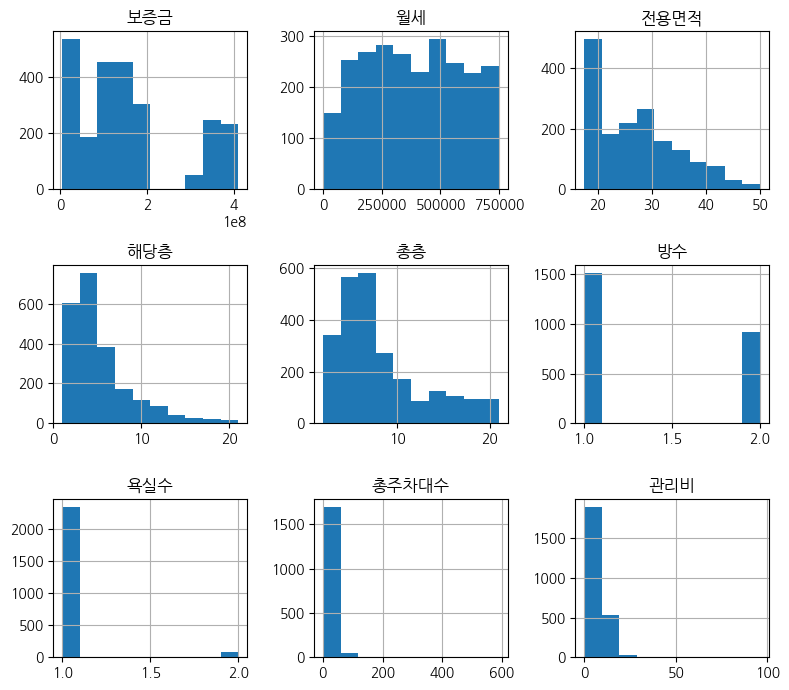

In [ ]:
numeric = train[['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비']]

numeric.hist(figsize=(8,7))
plt.tight_layout()
plt.show()

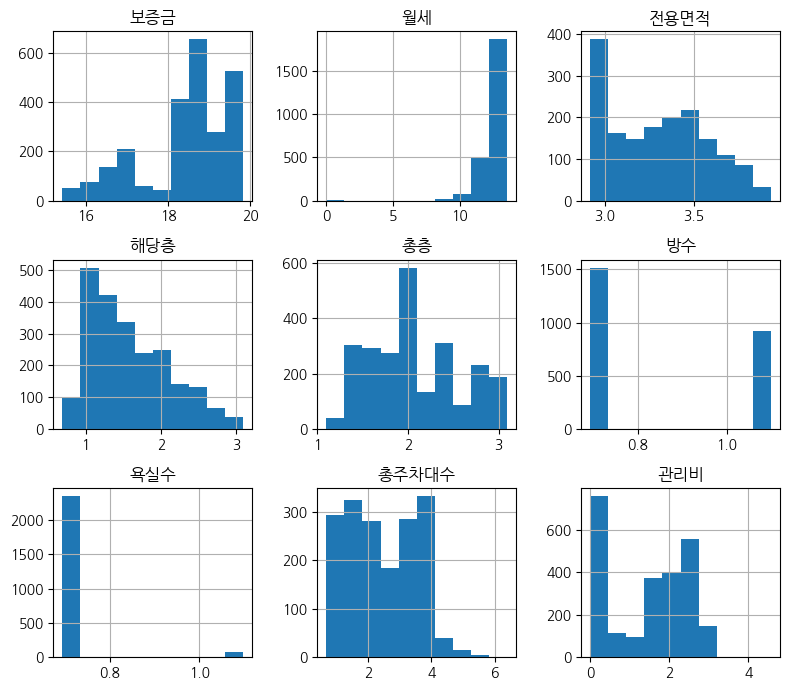

In [ ]:
numeric_log = train[['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비']]

#로그변환
numeric_log = np.log(numeric_log + 1)

numeric_log.hist(figsize=(8,7))
plt.tight_layout()
plt.show()

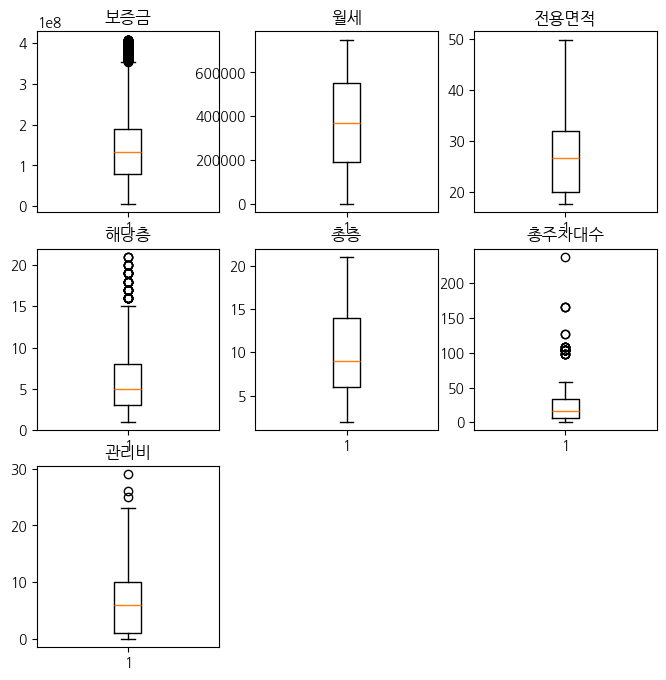

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

numeric = numeric.dropna()

axs[0, 0].boxplot(numeric['보증금'])
axs[0, 0].set_title("보증금")

axs[0, 1].boxplot(numeric['월세'])
axs[0, 1].set_title("월세")

axs[0, 2].boxplot(numeric['전용면적'])
axs[0, 2].set_title("전용면적")

axs[1, 0].boxplot(numeric['해당층'])
axs[1, 0].set_title("해당층")

axs[1, 1].boxplot(numeric['총층'])
axs[1, 1].set_title("총층")

axs[1, 2].boxplot(numeric['총주차대수'])
axs[1, 2].set_title("총주차대수")

axs[2, 0].boxplot(numeric['관리비'])
axs[2, 0].set_title("관리비")

axs[2, 1].axis("off")
axs[2, 2].axis("off")

plt.show()

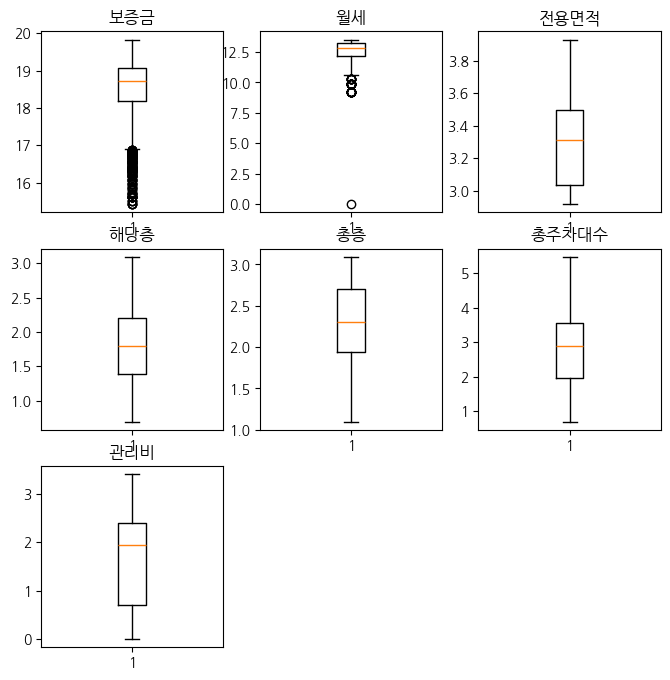

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
numeric_log = numeric_log.dropna()

axs[0, 0].boxplot(numeric_log['보증금'])
axs[0, 0].set_title("보증금")

axs[0, 1].boxplot(numeric_log['월세'])
axs[0, 1].set_title("월세")

axs[0, 2].boxplot(numeric_log['전용면적'])
axs[0, 2].set_title("전용면적")

axs[1, 0].boxplot(numeric_log['해당층'])
axs[1, 0].set_title("해당층")

axs[1, 1].boxplot(numeric_log['총층'])
axs[1, 1].set_title("총층")

axs[1, 2].boxplot(numeric_log['총주차대수'])
axs[1, 2].set_title("총주차대수")

axs[2, 0].boxplot(numeric_log['관리비'])
axs[2, 0].set_title("관리비")

axs[2, 1].axis("off")
axs[2, 2].axis("off")

plt.show()

In [ ]:
df[['해당층', '총층', '총주차대수', '관리비']] = np.log(df[['해당층', '총층', '총주차대수', '관리비']] + 1)

###인코딩

In [ ]:
df = pd.get_dummies(df, columns=['매물확인방식', '주차가능여부','방향'], drop_first=True)

# 변환할 컬럼만 int로 변경
cols_to_convert = [col for col in df.columns if col.startswith(('매물확인방식_', '주차가능여부_','방향_'))]
df[cols_to_convert] = df[cols_to_convert].astype(int)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩할 컬럼 리스트
label_cols = ['제공플랫폼']

# 각 컬럼에 대해 라벨 인코딩 적용
label_encoders = {col: LabelEncoder() for col in label_cols}
for col in label_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

###불필요 컬럼 삭제

In [ ]:
df.drop(columns=['게재일', 'ID','중개사무소'],inplace=True)

#학습하기

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.impute import KNNImputer

# KNN을 사용하여 결측치(이상치) 대체
imputer = KNNImputer(n_neighbors=5)  # 가까운 5개의 값을 참고하여 대체
df.iloc[:] = imputer.fit_transform(df.iloc[:])

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

In [ ]:
X_train = df.iloc[:len(train)]
X_test = df.iloc[len(train):]

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#
# 컬럼 이름을 문자열로 변환
X_train.columns = X_train.columns.astype(str)

# SMOTE로 데이터 증강 -> data 불균형 문제 해결 위함
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaler 초기화
scaler = StandardScaler()

# 복사본 생성
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 표준화할 열 목록
columns_to_scale = ['전용면적', '보증금', '월세', '관리비', '총주차대수', '해당층', '총층']

# X_train에 대해 표준화 수행
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# X_test에 대해 표준화 수행 (훈련 데이터의 스케일러 사용)
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# XGBoost 모델을 사용한 10-fold 교차 검증
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_predictions = cross_val_predict(xgb_model, X_train_scaled, y_train, cv=10)

# XGBoost에 대한 classification report
print("XGBoost Classification Report:")
print(classification_report(y_train, xgb_predictions))
xgb_accuracy = accuracy_score(y_train, xgb_predictions)
xgb_f1score = f1_score(y_train, xgb_predictions, average='weighted')

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost F1-score:", xgb_f1score)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2154
           1       0.97      0.97      0.97      2154

    accuracy                           0.97      4308
   macro avg       0.97      0.97      0.97      4308
weighted avg       0.97      0.97      0.97      4308

XGBoost Accuracy: 0.968895078922934
XGBoost F1-score: 0.9688947504206659


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# LightGBM 모델을 사용한 10-fold 교차 검증
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbose = -1)
lgb_predictions = cross_val_predict(lgb_model, X_train_scaled, y_train, cv=10)

# LightGBM에 대한 classification report
print("\nLightGBM Classification Report:")
print(classification_report(y_train, lgb_predictions))

lgb_accuracy = accuracy_score(y_train, lgb_predictions)
lgb_f1score = f1_score(y_train, lgb_predictions, average='weighted')

print("\nLightGBM Accuracy:", lgb_accuracy)
print("LightGBM F1-score:", lgb_f1score)


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2154
           1       0.97      0.97      0.97      2154

    accuracy                           0.97      4308
   macro avg       0.97      0.97      0.97      4308
weighted avg       0.97      0.97      0.97      4308


LightGBM Accuracy: 0.9670380687093779
LightGBM F1-score: 0.9670379550401966


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Rfoost 모델을 사용한 10-fold 교차 검증
Rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
Rf_predictions = cross_val_predict(Rf_model, X_train_scaled, y_train, cv=10)

# Rfoost에 대한 classification report
print("Rfoost Classification Report:")
print(classification_report(y_train, Rf_predictions))
Rf_accuracy = accuracy_score(y_train, Rf_predictions)
Rf_f1score = f1_score(y_train, Rf_predictions, average='weighted')

print("Rfoost Accuracy:", Rf_accuracy)
print("Rfoost F1-score:", Rf_f1score)

Rfoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2154
           1       0.91      0.97      0.94      2154

    accuracy                           0.94      4308
   macro avg       0.94      0.94      0.94      4308
weighted avg       0.94      0.94      0.94      4308

Rfoost Accuracy: 0.9375580315691736
Rfoost F1-score: 0.9375070879733776


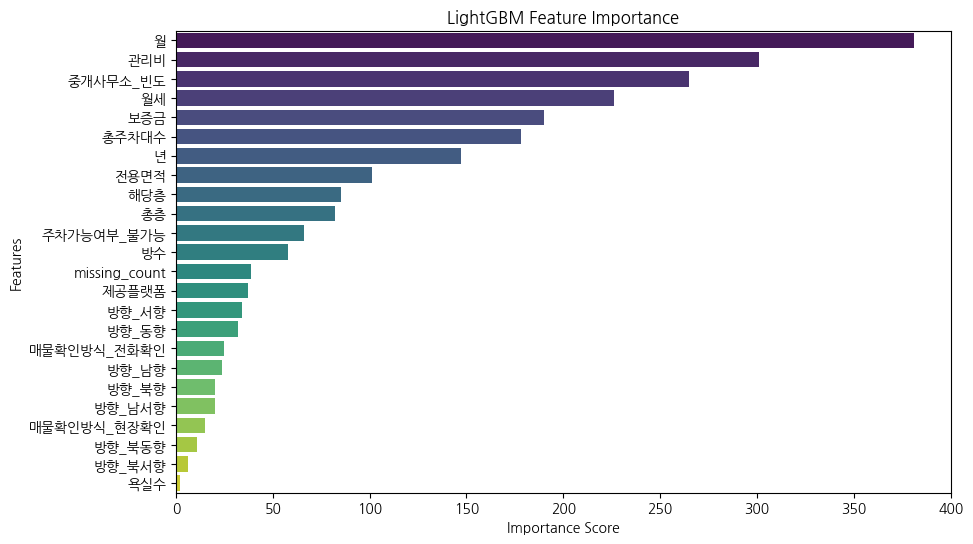

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, f1_score

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbose=-1)
lgb_model.fit(X_train_scaled, y_train)

# Feature Importance 가져오기
feature_importance = lgb_model.feature_importances_
feature_names = X_train_scaled.columns

# 데이터프레임으로 변환 후 정렬
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

#데이콘 제출

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, verbose=-1)
xgb_model.fit(X_train_scaled, y_train)

# 테스트 데이터에 대해 예측
xgb_predictions = xgb_model.predict(X_test_scaled)

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbose=-1)
lgb_model.fit(X_train_scaled, y_train)

# 테스트 데이터에 대해 예측
lgb_predictions = lgb_model.predict(X_test_scaled)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 가이드 프로젝트/sample_submission.csv')
submit['허위매물여부'] = lgb_predictions
submit.to_csv('/content/drive/MyDrive/colab_data/Dscover 25-1 가이드 프로젝트/baseline_submission.csv',index=False)